# Detection, tracking and location of runways on visual approaches

projeto realizado para o curso "EA979 - INTRODUÇÃO À COMPUTAÇÃO GRÁFICA E AO PROCESSAMENTO DE IMAGEM"

- Daniel Gonçalves Benvenutti 169448
- Matteo Di Fabio 264339
- Renan Sterle 176536

## Introduction and Motivation

Both in military aviation as well as in civil aviation, visual flight rules (VFR) remain of great importance nowadays. Particularly in airports and terminals of reduced infrastructure, visual approach and landing procedures account for the majority of cases and such procedures rely on visibility conditions, visual navigational aids and personal performance of the pilot in command. 
In any type of landing approach, the maintenance of a safe flight envelope is crucial. Therefore, during the final approach leg, parameters such as airspeed, altitude, descent rate, glide slope, ground clearance, as well as location in relation to the runway must be monitored and corrected.
While airspeed, altitude and descent rate are measure by the aircraft, the other parameters can only be determined with the use of external information. In the case of instrument flight rules (IFR), Instrument Landing Systems (ILS), Global Navigation Satellite System (GNSS), inertial navigation systems and radio beacons provide such information, whereas on VFR they are ultimately estimated visually
by the pilot.

The idea of this project is to implement a system that:

1. Given a picture of an approach, identifies and isolates the runway in question, using image processing filtering and segmentation techniques (parágrafo IdentifyRunway);
2. Fits the runway image into the expected runway shape by applying perspective and affine transformations (parágrafo Correct);
3. Determines the camera point of view in relation to the runway start. Alignment, lateral offset and distance information are the most important, while relative altitude is of secondary importance (parágrafo Calculos openCV);
4. Tracks the identified runway in a stream of frames, validating and checking the correlation of the results between different frames of a temporal sequence; (essa etapa è da remover????)



# check the list to see if i "linked" the right paragraph/code
# Daniel code is missing i don't know where to put it

## Main Explanation

##### is not a definitive one, for now its for you to understand my idea and give me a feedback
using this code we have a main that use the python library wrote by us. This main read the image into the Path variable and create a folder named Results inside the folder where is this notebook and after that create a folder with the same name of the image where we can fine all the image processed to achieve the final result.
instead of writing a aprameter into the command line, we only need to change the value of the variable  Path.

15 16


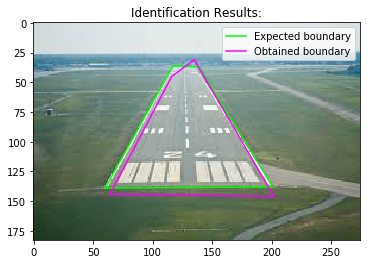

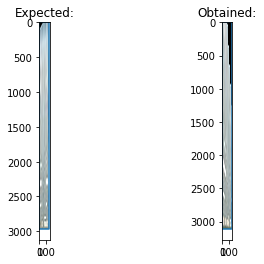

In [16]:
import sys;
import os.path;
import json;

import IdentifyRunway;
import Display;
import Correct;

def ReadJSON(JSONPath, Path):
    File = open(JSONPath, "r");
    Data = json.loads(File.read());
    Data["Image"] = Path;
    File.close();
    return Data;

def Main():
    Path='../DataSet/Selected/Real/07.jpeg'
    #Path='../DataSet/Selected/Simulation/07.jpg'
    ExportPath = './Results' + '/' + os.path.splitext(os.path.basename(Path))[0]
    
    if (not os.path.exists('./Results')):
        os.makedirs('./Results', exist_ok = True);
    
    if (not os.path.exists(ExportPath)):
        os.makedirs(ExportPath, exist_ok = True);
                           
    JSONPath = os.path.splitext(Path)[0]+".txt";
    if (not os.path.exists(Path)):
        sys.exit("File does not exist.");
    if (not os.path.exists(JSONPath)):
        sys.exit("JSON file does not exist.");

    JSON = ReadJSON(JSONPath, Path);
    JSON = IdentifyRunway.IdentifyRunway(JSON, ExportPath);
    Display.Display(JSON, ExportPath);
    Correct.Correct(JSON, ExportPath);
    
    
    #Export JSON:
    if (ExportPath is not None):
        File = open(ExportPath + "/11 JSON.txt", "w");
        json.dump(JSON, File, indent = 4);
        File.close();
        
if (__name__ == "__main__"):
    Main()

# IdentifyRunway Explanation

para prosseguir com a segmentação da pista de pouso, várias estradas eram praticáveis.
uma era a conversão de imagem em escala de cinza e, em seguida, a segmentação com otsu após o pré-processamento, mas nesse caso, a grama nas laterais da pista e a pista em si tinham um cinza semelhante, às vezes até o céu, por isso era difícil encontrar valores automáticos que permitissem a segmentação. por esse motivo, tentamos segmentar uma imagem convertida em HSV, mas também nesse caso, não foi possível encontrar valores padrão que permitissem identificar a faixa em várias imagens diferentes. Nesse ponto, foi decidido agir diretamente na imagem original seguindo as seguintes etapas:

1. Contraste -> realça a pista;
2. Blur (filtragem bilateral) ->torna homogêneas as áreas com cor similares mantendo as bordas nítidas;
3. Canny -> acha as bordas;
4. Crop -> corta uma área de cada borda da imagem porque para algumas imagens o canny acha o contorno da imagem e isso atrapalha;
5. Dilatação -> funde as bordas encontradas pelo canny e simplifica o processo; Com menos bordas mais grossas a chance de encontras as corretas aumenta.
6. Hough -> identifica as retas;
7. Filtrar as linhas -> A gente ignora as retas que são muito pouco inclinadas;
8. Todas as retas encontradas pelo Hough são desenhadas na imagem -> os segmentos se fundam e se agrupem. (É a mesma idéia da dilatação);
9. Hough (de novo) -> encontra as retas que são na verdade o agrupamento e simplificação das retas encontradas pelo primeiro Hough;
10. Otimização -> de todas as retas encontradas no 9, encontramos os 4 pontos com quais podemos construir duas retas que melhor sobrepõe as bordas sobrepostas do 8. 

In [ ]:
import sys;
import cv2;
import numpy as np;
import operator;
import copy;

def Cart2Pol(P):
	Rho = np.sqrt(P[0]**2 + P[1]**2);
	Phi = np.arctan2(P[1], P[0]);
	return ([Rho, Phi]);

def Pol2Cart(P):
	return([P[0] * np.cos(P[1]), P[0] * np.sin(P[1])]);

def IdentifyRunway(JSON, ExportPath):
	RawImage = cv2.imread(JSON["Image"]);
	Result = copy.copy(RawImage);

	# 1. Enhance contrast;
	Alpha = 3.0;
	Beta = -Alpha*np.mean(cv2.mean(RawImage)[0:3]);
	Contrast = cv2.convertScaleAbs(RawImage, alpha = Alpha, beta = Beta);

	# 2. Blur;
	sigmaColor = [40, 200];
	sigmaSpace = 10;
	Blur1 = cv2.bilateralFilter(Contrast, d = 0, sigmaColor = sigmaColor[0], sigmaSpace = sigmaSpace, borderType = cv2.BORDER_WRAP);
	Blur2 = cv2.bilateralFilter(Contrast, d = 0, sigmaColor = sigmaColor[1], sigmaSpace = sigmaSpace, borderType = cv2.BORDER_WRAP);

	# 3. Canny;
	Edges1 = cv2.Canny(Blur1, 100, 300);
	Edges2 = cv2.Canny(Blur2, 80, 150);

	# 4. Crop:
	Margin = 5;
	Edges1 = Edges1[Margin:-Margin, Margin:-Margin];
	Edges2 = Edges2[Margin:-Margin, Margin:-Margin];

	# 5. Dilatation:
	KernelSize = 3;
	Kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (KernelSize, KernelSize));
	Dilation1 = cv2.dilate(Edges1, Kernel, iterations = 1);
	Dilation2 = cv2.dilate(Edges2, Kernel, iterations = 1);

	# 6. Hough 1;
	Lines1 = cv2.HoughLinesP(Dilation1, 1, np.pi/180, threshold = 40, minLineLength = 60, maxLineGap = 5);
	Lines2 = cv2.HoughLinesP(Dilation2, 1, np.pi/180, threshold = 40, minLineLength = 60, maxLineGap = 5);

	# 7. Merge and filter lines;
	MinAngle = 30*np.pi/180;
	Lines = list();
	for X in Lines1:
		Delta = np.asarray([X[0][0], X[0][1]])-np.asarray([X[0][2], X[0][3]]);
		Angle = np.arctan(Delta[1]/Delta[0]);
		if (np.abs(Angle) > MinAngle):
			Lines.append(X[0]);
			
	for X in Lines2:
		Delta = np.asarray([X[0][0], X[0][1]])-np.asarray([X[0][2], X[0][3]]);
		Angle = np.arctan(Delta[1]/Delta[0]);
		if (np.abs(Angle) > MinAngle):
			Lines.append(X[0]);

	# 8. Line processing:
	Edges = np.zeros(Edges1.shape, np.uint8);
	LineWidth = 4;
	for L in Lines:
		cv2.line(Result, (L[0]+Margin, L[1]+Margin), (L[2]+Margin, L[3]+Margin), (0, 255, 0), 1);
		cv2.line(Edges, (L[0]+Margin, L[1]+Margin), (L[2]+Margin, L[3]+Margin), (255, 255, 255), LineWidth);
		cv2.circle(Result, (L[0]+Margin, L[1]+Margin), 2, (255, 0, 0), -1);
		cv2.circle(Result, (L[2]+Margin, L[3]+Margin), 2, (255, 0, 0), -1);

	# 9. Hough 2:
	Lines = cv2.HoughLinesP(Edges, 1, np.pi/180, threshold = 20, minLineLength = 40, maxLineGap = 8);
	DrawnEdges = cv2.cvtColor(Edges, cv2.COLOR_GRAY2RGB);
	for X in Lines:
		cv2.line(DrawnEdges, (X[0][0]+Margin, X[0][1]+Margin), (X[0][2]+Margin, X[0][3]+Margin), (0, 0, 255), 1);

	# 10. Modelling:
	Max = 0;
	BestI = 0;
	BestJ = 0;
	LineWeight = 8;
	for I, X in enumerate(Lines):
		for J, Y in enumerate(Lines):
			print(I, len(Lines), end = '\r');
			TmpEdges = copy.copy(Edges);
			cv2.line(TmpEdges, (X[0][0]+Margin, X[0][1]+Margin), (X[0][2]+Margin, X[0][3]+Margin), (0, 0, 0), LineWeight);
			cv2.line(TmpEdges, (Y[0][0]+Margin, Y[0][1]+Margin), (Y[0][2]+Margin, Y[0][3]+Margin), (0, 0, 0), LineWeight);
			Count = np.count_nonzero(TmpEdges == 0);
			if (Count > Max):
				Max = Count;
				BestI = I;
				BestJ = J;
	print("");

	X = Lines[BestI][0];
	Y = Lines[BestJ][0];
	
	#Cartesian coordinates:
	A = (X[0]+Margin, X[1]+Margin);
	B = (X[2]+Margin, X[3]+Margin);
	C = (Y[0]+Margin, Y[1]+Margin);
	D = (Y[2]+Margin, Y[3]+Margin);

	#Draw results:
	cv2.line(DrawnEdges, A, B, (255, 0, 255), 5);
	cv2.line(DrawnEdges, C, D, (255, 0, 255), 5);
	cv2.circle(Result, A, 5, (0, 255, 255), -1);
	cv2.circle(Result, B, 5, (0, 255, 255), -1);
	cv2.circle(Result, C, 5, (0, 255, 255), -1);
	cv2.circle(Result, D, 5, (0, 255, 255), -1);

	A = np.asarray(A);
	B = np.asarray(B);
	C = np.asarray(C);
	D = np.asarray(D);
	Center = (A+B+C+D)/4;

	#Sort vertex:
	Vertex = list();
	Vertex.append(Cart2Pol(A-Center));
	Vertex.append(Cart2Pol(B-Center));
	Vertex.append(Cart2Pol(C-Center));
	Vertex.append(Cart2Pol(D-Center));
	Vertex.sort(key = lambda X: X[1]);
	
	#Add results to JSON:
	JSON["Results"] = dict();
	JSON["Results"]["L0"] = (Pol2Cart(Vertex[3])+Center).tolist();
	JSON["Results"]["R0"] = (Pol2Cart(Vertex[2])+Center).tolist();
	JSON["Results"]["L1"] = (Pol2Cart(Vertex[0])+Center).tolist();
	JSON["Results"]["R1"] = (Pol2Cart(Vertex[1])+Center).tolist();
	
	#Show results:
	cv2.imshow("RawImage", RawImage);
	cv2.imshow("Contrast", Contrast);
	cv2.imshow("Blur1", Blur1);
	cv2.imshow("Blur2", Blur2);
	cv2.imshow("Edges1", Edges1);
	cv2.imshow("Edges2", Edges2);
	cv2.imshow("Drawn Edges", DrawnEdges);
	cv2.imshow("Result", Result);
	
	#Export images:
	if (ExportPath is not None):
		cv2.imwrite(ExportPath+"/01 Image.jpg", RawImage);
		cv2.imwrite(ExportPath+"/02 Contrast.jpg", Contrast);
		cv2.imwrite(ExportPath+"/03 Blur1.jpg", Blur1);
		cv2.imwrite(ExportPath+"/04 Blur2.jpg", Blur2);
		cv2.imwrite(ExportPath+"/05 Edges1.jpg", Edges1);
		cv2.imwrite(ExportPath+"/06 Edges2.jpg", Edges2);
		cv2.imwrite(ExportPath+"/07 DrawnEdges.jpg", DrawnEdges);
		cv2.imwrite(ExportPath+"/08 Result.jpg", Result);

	cv2.waitKey(0);
	cv2.destroyAllWindows();

	return JSON;


## display explanation

In [ ]:
import sys;
import os;
import numpy as NP;
from PIL import Image;
import matplotlib;
#matplotlib.use("GTK3Agg");
import matplotlib.pyplot as PLT;
import json;

def Display(JSON, ExportPath):
	Figure = PLT.figure("Identification")
	F = Figure.add_subplot(1, 1, 1);
	F.imshow(Image.open(JSON["Image"]));

	Runway = JSON["Runway"];
	L0 = Runway["L0"];
	R0 = Runway["R0"];
	L1 = Runway["L1"];
	R1 = Runway["R1"];

	P = NP.transpose(NP.vstack([L0, L1, R1, R0, L0]));

	#Plot expected:
	F.plot(P[0], P[1], label = "Expected boundary", color = "lime");
	F.legend();

	Results = JSON["Results"];
	L0 = Results["L0"];
	R0 = Results["R0"];
	L1 = Results["L1"];
	R1 = Results["R1"];

	P = NP.transpose(NP.vstack([L0, L1, R1, R0, L0]));

	#Plot obtained:
	F.plot(P[0], P[1], label = "Obtained boundary", color = "magenta");
	F.legend();

	PLT.title("Identification Results:")
	PLT.show();
	
	#Export plot:
	if (ExportPath is not None):
		Figure.savefig(ExportPath + "/09 Display.png");


## correct explanation

In [ ]:
import sys;
import os;
import numpy as NP;
from PIL import Image;
import matplotlib;
#matplotlib.use("GTK3Agg");
import matplotlib.pyplot as PLT;
import json;

def PerspectiveCoefficients(A, B):
	matrix = [];
	for p1, p2 in zip(A, B):
		matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]]);
		matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]]);

	A = NP.matrix(matrix, dtype=NP.float)
	B = NP.array(B).reshape(8)

	res = NP.dot(NP.linalg.inv(A.T * A) * A.T, B)
	return NP.array(res).reshape(8)

def Correction(I, Points, Width, Length):
	L0 = NP.array(Points["L0"]);
	R0 = NP.array(Points["R0"]);
	L1 = NP.array(Points["L1"]);
	R1 = NP.array(Points["R1"]);

	C0 = (L0+R0)/2.0;
	C1 = (L1+R1)/2.0;
	C = (C0+C1)/2.0;
	D = C0-C1;
	Angle = NP.arctan2(D[0], D[1]);

	#Rotate image:
	I = I.rotate(NP.degrees(-Angle), Image.BICUBIC, False, (C[0], C[1]));

	#Rotate points:
	Cos, Sin = NP.cos(Angle), NP.sin(Angle);
	Rotation = NP.array(((Cos, -Sin), (Sin, Cos)));
	[L0, R0, L1, R1, C_] = NP.transpose(NP.matmul(Rotation, NP.c_[L0, R0, L1, R1, C]));

	#Correct center offset:
	D = C-C_;
	[L0, R0, L1, R1] = [L0, R0, L1, R1]+D;

	D = R0-L0;
	ShearFactor = D[1]/D[0];
	#Shear image:
	Shear = NP.eye(3);
	Shear[1][0] = ShearFactor;
	I = I.transform(I.size, Image.AFFINE, Shear.flatten()[:6], Image.BICUBIC);

	#Shear points:
	Shear = NP.eye(2);
	Shear[1][0] = -ShearFactor;
	[L0, R0, L1, R1] = NP.transpose(NP.matmul(Shear, NP.c_[L0, R0, L1, R1]));

	#Crop image:
	Y0 = (R0[1]+L0[1])/2.0;
	Y1 = (R1[1]+L1[1])/2.0;
	X0 = L0[0];
	X1 = X0+R0[0]-L0[0];
	I = I.crop((X0, Y1, X1, Y0));

	D = NP.array([X0, Y1]);
	[L0, R0, L1, R1] = [L0, R0, L1, R1]-D;

	Runway = JSON["Runway"];
	Width = NP.array(Runway["Width"]);
	Length = NP.array(Runway["Length"]);

	A, PA = Correction(I, JSON["Runway"], Width, Length);
	B, PB = Correction(I, JSON["Results"], Width, Length);

	Figure = PLT.figure("Correction")
	F = Figure.add_subplot(1, 2, 1);
	F.imshow(A);
	F.plot(PA[0], PA[1]);
	F.title.set_text("Expected:");
	F = Figure.add_subplot(1, 2, 2);
	F.imshow(B);
	F.plot(PB[0], PB[1]);
	F.title.set_text("Obtained:");
	
	#Export plot:
	if (ExportPath is not None):
		Figure.savefig(ExportPath + "/10 Correct.png");

	PLT.show();
